### **1. Goals, Constraints, and Reuse from NB01**

**What we are building today**
In this notebook, we turn the sliding-window dataset from NB01 into **working next-day forecasters**. We will train **three sequence models** on exactly the same inputs so our comparison is fair and easy to interpret:

- **Vanilla RNN (baseline):** a minimal recurrent model that processes each 7-day window and predicts the next temperature. This gives us a *reference point* for accuracy, stability, and speed.
- **LSTM:** an RNN with **gates** and a **cell state** designed to keep useful information alive longer. We expect it to handle patterns that a plain RNN might forget.
- **GRU:** a lighter-weight gated RNN that often matches LSTM performance with fewer parameters and slightly faster training.

Our task is **single-step forecasting**: given a window of 7 past days, predict **tomorrow’s** temperature.

**Practical constraints (so everything runs smoothly on CPU)**
We will keep training **CPU-only** and fast. That means:
- **Short training** (aim for \< 5 minutes total): modest number of epochs (e.g., 15–25), small hidden sizes (e.g., 64), and batch size around 64.
- **Stable optimization:** we’ll use `Adam` with a conservative learning rate and apply **gradient clipping** to avoid instability.
- **Simple heads:** for all models, we’ll take the **last time step’s hidden state** and pass it through a small linear layer to predict a single value.

These choices keep the focus on **sequence learning** rather than heavy engineering.

**What we reuse from NB01 (so we stay consistent)**
We have already prepared everything needed to start modeling. We will **reuse** the exact artifacts and shapes created in NB01:

- **Data split with time order respected:** `df_train`, `df_test` (1981–1988 → train, 1989–1990 → test).
- **Scaling with no leakage:** a **fitted** `scaler` (MinMax) from train only; `train_scaled`, `test_scaled` are the transformed series.
- **Supervised framing:** `window_size = 7` so each input window is 7 days and the target is day 8.
- **Ready tensors for PyTorch:** `X_train`, `y_train`, `X_test`, `y_test` created via sliding windows.
- **Dataloaders (batch-first):** `train_loader`, `test_loader` that yield batches shaped like **`(batch, seq_len, 1)`**, e.g., `(64, 7, 1)`.

Because we keep **all models** on the **same inputs and preprocessing**, any difference in performance reflects the **sequence model** itself rather than data handling.

**How we will evaluate (and why)**
During training, we minimize **Mean Squared Error (MSE)** on the **scaled** values (0–1). This keeps gradients well-behaved.  
For final reporting and plots, we will **invert the scaling** using the same `scaler` so that predictions and targets return to **°C**. Then we will compute:

- **MAE (Mean Absolute Error)** in °C → easy to read (“average absolute miss”).
- **RMSE (Root Mean Squared Error)** in °C → penalizes larger mistakes more strongly.

We will also **visualize**:
- **Actual vs. predicted** curves on a slice of the test set (to see patterns the model captures or misses),
- Optionally **scatter** (pred vs. actual) and **residuals** to diagnose bias and variance.

This separation—**optimize in scaled space, judge in °C**—gives us both stable training and interpretable conclusions.

**What to keep in mind as we compare models**
- All three models see **the same windows** and **the same batches**.
- We stick to **batch-first** tensors `(batch, seq_len, input_size)` for readability (we learned time-first thoroughly in Project 7; switching layouts does **not** change the math).
- Hyperparameters (window size, hidden size, epochs, batch size) are kept **identical across models** so we can attribute differences to the **recurrent cell** (RNN vs. LSTM vs. GRU).

**Reflection**
**What weaknesses do we expect from a Vanilla RNN on this dataset?**  
Let’s think about **short memory** and **recency bias**: will a plain RNN lean too heavily on the most recent few days and miss the lead-ups to seasonal peaks/troughs?

**How might LSTM/GRU help?**  
Gates and a cell state allow these models to **store** or **forget** information deliberately, which should help when the next day depends on **patterns across the whole window** (and, later, on longer spans when we experiment with bigger windows).

---

### **2. Shape Convention, Seeds, and a Batch Peek**

**Our shape convention in NB02**
In this notebook, we will use the **batch-first** layout:  
$$(\text{batch},\ \text{seq\_len},\ \text{input\_size})$$

- For our problem, that’s typically $(B,\, 7,\, 1)$ since we use a 7-day window and one feature (temperature).
- We learned the **time-first** view in Project 7 because it mirrors recurrence:  
  $$(\text{seq\_len},\ \text{batch},\ \text{input\_size})$$
- Both layouts are valid; **the math inside RNN/LSTM is identical**. If a layer expects time-first, we convert a batch-first tensor with:  
  $$X_{\text{time-first}}=\operatorname{permute}\!\left(X_{\text{batch-first}}, (1,0,2)\right)$$
  i.e., $(B,\,S,\,F)\rightarrow(S,\,B,\,F)$.

> **Why batch-first here?** After NB01, our dataset is naturally “one row = one window,” so reading $(B,\,S,\,F)$ is simpler and avoids constant permutation. We still know how to switch if a layer needs time-first.

**Why seeds matter (reproducibility)**
Deep learning training involves randomness (weight initialization, shuffling, etc.).  
By fixing **random seeds**, we ensure that:
- we (and our students) can **reproduce** runs,
- small differences we see are from **model choices**, not from chance.

We’ll set seeds for Python, NumPy, and PyTorch.

**Code: set seeds + peek a batch (confirm shapes)**

In [1]:
import pandas as pd
import random, numpy as np, torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

# 1) Load the dataset (adjust path if needed)
# Expecting two columns: Date (MM/DD/YY), Temp
df = pd.read_csv("dataset/1_Daily_minimum_temps.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%y")
df["Temp"] = pd.to_numeric(df["Temp"], errors="coerce")
df = df.set_index("Date").dropna(subset=["Temp"])

# 2) Time-aware split (1981–1988 train, 1989–1990 test)
split_date = pd.Timestamp("1989-01-01")
df_train = df.loc[: split_date - pd.Timedelta(days=1)]
df_test  = df.loc[split_date :]

# 3) Scale with train-only fit (MinMax to [0,1])
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_train[["Temp"]])
train_scaled = scaler.transform(df_train[["Temp"]])
test_scaled  = scaler.transform(df_test[["Temp"]])

# 4) Sliding windows → (N, window_size, 1) and (N, 1)

def create_sliding_windows(series, window_size=7):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    X = np.array(X); y = np.array(y)
    return X.reshape((X.shape[0], X.shape[1], 1)), y.reshape((-1, 1))

WINDOW_SIZE = 7
X_train, y_train = create_sliding_windows(train_scaled, WINDOW_SIZE)
X_test,  y_test  = create_sliding_windows(test_scaled,  WINDOW_SIZE)

# 5) TensorDataset + DataLoader (batch-first)
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

# --- Peek a batch and confirm shapes ---
xb, yb = next(iter(train_loader))
print("Batch X shape (batch-first):", xb.shape)   # expect (B, 7, 1)
print("Batch y shape:", yb.shape)                 # expect (B, 1)

# --- Show time-first view if needed ---
xb_time_first = xb.permute(1, 0, 2)
print("Time-first view of X:", xb_time_first.shape)  # (7, B, 1)

Batch X shape (batch-first): torch.Size([64, 7, 1])
Batch y shape: torch.Size([64, 1])
Time-first view of X: torch.Size([7, 64, 1])


**Reflection**
- **Why doesn’t changing layout change the math?**  
  Because we are only **reordering axes** (batch vs. time), not changing the recurrence equations. The layer will consume the same sequence of vectors $x_{1},\dots,x_{S}$ and update hidden states in the same way; we just present the tensor with a different axis order.

- **When would we pick time-first vs batch-first?**  
  - **Time-first** $(S,\,B,\,F)$ helps us think in a **time-driven** way (great for learning how recurrence flows).  
  - **Batch-first** $(B,\,S,\,F)$ is often **easier** once the dataset is organized row-wise as windows; it avoids extra permutations in most training loops.  
  In this project, we prefer **batch-first** for readability, but we are fully equipped to switch if needed with a single $\operatorname{permute}(1,0,2)$.

---

### **3. LSTM vs. Vanilla RNN (Intuition + a Little Math)**

**Quick RNN recap — what it remembers and why it forgets**

A **Vanilla RNN** processes one step at a time. At time step $t$ we update a hidden state $h_t$ from the current input $x_t$ and the previous state $h_{t-1}$:
$$
h_t \;=\; \tanh\!\big(W_{xh}\,x_t \;+\; W_{hh}\,h_{t-1} \;+\; b_h\big),
\qquad
\hat{y}_t \;=\; W_{hy}\,h_t \;+\; b_y.
$$
During training we do **Backpropagation Through Time (BPTT)**. The gradients flowing from step $t$ back to earlier steps multiply many Jacobians (e.g., terms like $\operatorname{diag}(1-\tanh^2(\cdot))\,W_{hh}$). If the dominant singular values are $<1$, gradients **shrink** (vanish); if $>1$, they **blow up**.  
**Meaning for us:** a plain RNN tends to remember only **short** contexts — it leans heavily on the most recent few days and can **forget slower patterns**.

> Intuition: RNN memory $\approx$ a **sticky note** — great for the next few steps, easy to lose older information.

**LSTM — adding a regulated memory (cell state + gates)**

An **LSTM** augments the hidden state $h_t$ with a **cell state** $c_t$ (longer-term memory) and three **gates** that control what to keep, write, and reveal. At each step:
$$
\begin{aligned}
i_t &= \sigma\!\big(W_{xi}x_t + W_{hi}h_{t-1} + b_i\big) &&\text{(input gate; how much new info to write)}\\
f_t &= \sigma\!\big(W_{xf}x_t + W_{hf}h_{t-1} + b_f\big) &&\text{(forget gate; how much old info to keep)}\\
o_t &= \sigma\!\big(W_{xo}x_t + W_{ho}h_{t-1} + b_o\big) &&\text{(output gate; how much memory to expose)}\\
\tilde{c}_t &= \tanh\!\big(W_{xc}x_t + W_{hc}h_{t-1} + b_c\big) &&\text{(candidate content)}\\[4pt]
c_t &= f_t \odot c_{t-1} \;+\; i_t \odot \tilde{c}_t \\
h_t &= o_t \odot \tanh(c_t)
\end{aligned}
$$
Here $\sigma(\cdot)$ is the logistic sigmoid (outputs in $(0,1)$), and $\odot$ is element-wise multiplication.

**Why this helps with long memory:**  
If $f_t \approx 1$ and $i_t \approx 0$ for several steps, the update becomes $c_t \approx c_{t-1}$ — the **cell state travels forward nearly unchanged**. Its gradient also travels with **minimal shrinking**, a property sometimes called the “constant error carousel.” We can then **preserve** important information across many steps and decide **when** to update or expose it via $i_t$ and $o_t$.

> Intuition: LSTM memory $\approx$ a **whiteboard with knobs** — we can *erase* (forget), *write* (input), and *reveal* (output) information on demand.

**Why gates help on our temperature data**
Our inputs are **7-day windows** of daily minimum temperatures. Even within a week, useful signals include:
- **Short warm/cool spells** (runs of a few days),
- **Lead-ups to peaks/troughs** (shoulder effects before seasonal highs/lows),
- **Noisy day-to-day wiggles** we’d rather ignore.

A plain RNN tends to **overweight the last 1–2 days** (recency bias) and can forget the start of the window. An LSTM can **learn to keep** a smoothed representation of the week (via $c_t$) and update it **selectively** with $i_t, f_t$. In practice, that often yields **steadier** next-day forecasts, especially around transitions (e.g., cooling after a hot spell).

**TL;DR comparison (for our task)**
- **RNN:** simpler, fewer parameters, but **short effective memory**; may lag or overfit to the most recent points.  
- **LSTM:** more parameters (gates + cell) but **longer, controllable memory**; better at capturing structured patterns across the whole window.

We will train **all three** (RNN baseline, LSTM, and GRU later) on the exact same windows so we can **see** these differences in metrics and plots rather than just theory.

**Reflection**
- In our own words: **why** can an LSTM remember longer than an RNN?  
- Looking at our temperature series, **where** will longer memory help most — sharp drops, rebounds after peaks, or shoulder seasons?

---

### **4. Time-First vs Batch-First (Teaching Note + Tiny `permute` Demo)**

**Why we’re using batch-first in NB02**
In Project 7, we emphasized the **time-first** view because it mirrors recurrence:
$$
(\text{seq\_len},\ \text{batch},\ \text{input\_size}).
$$
That layout helps us “see” time flowing across steps.

Now that we understand the architecture, we’ll work with **batch-first** in NB02:
$$
(\text{batch},\ \text{seq\_len},\ \text{input\_size}),
$$
which matches how our sliding-window dataset is organized: one row per training example (window). This makes shapes easier to read in practice, and we can always swap to time-first with a single `permute` if a layer expects it.

> **Key idea:** Changing layout reorganizes axes; it does **not** change the LSTM/RNN math. The same sequence $x_1,\dots,x_S$ is processed step-by-step; we just present the tensor with a different axis order.

**API choices (both layouts are supported)**
We can choose either layout when we **define the layer**:
```python
import torch.nn as nn

# Time-first (default): expects (seq_len, batch, input_size)
rnn_tf  = nn.RNN(input_size=1, hidden_size=64, batch_first=False)
lstm_tf = nn.LSTM(input_size=1, hidden_size=64, batch_first=False)

# Batch-first: expects (batch, seq_len, input_size)
rnn_bf  = nn.RNN(input_size=1, hidden_size=64, batch_first=True)
lstm_bf = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
```
If we ever need to switch a batch from batch-first to time-first, we apply:

$$
\mathbf{X}_{\text{time-first}} = \texttt{permute}(\mathbf{X}_{\text{batch-first}},\ (1,\ 0,\ 2)).
$$

**🧪 Tiny permute demo (see the axes move, not the values)**

We’ll build a small tensor with obvious indexing so we can track a single element through the permutation.


In [2]:
import torch

# Build a tiny tensor with shape (B, S, F) = (2, 3, 4)
t = torch.arange(2*3*4).view(2, 3, 4)
print("Original (batch-first) shape:", t.shape)     # (2, 3, 4)
print(t)                                            # values 0..23 for easy tracking

# Pick one element in batch-first indexing (batch=1, step=2, feat=3)
v1 = t[1, 2, 3].item()
print("t[1, 2, 3] =", v1)

# Convert to time-first: (S, B, F) by permuting axes (1,0,2)
t_tf = t.permute(1, 0, 2)
print("Time-first shape:", t_tf.shape)              # (3, 2, 4)

# The same scalar must now live at [step, batch, feat] = [2, 1, 3]
v2 = t_tf[2, 1, 3].item()
print("t_tf[2, 1, 3] =", v2)

print("Same value before/after permute?", v1 == v2)

# (Optional) Switching back recovers the original tensor exactly
t_back = t_tf.permute(1, 0, 2)
print("Back to batch-first shape:", t_back.shape)
print("Restored equals original?", torch.equal(t_back, t))


Original (batch-first) shape: torch.Size([2, 3, 4])
tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]]])
t[1, 2, 3] = 23
Time-first shape: torch.Size([3, 2, 4])
t_tf[2, 1, 3] = 23
Same value before/after permute? True
Back to batch-first shape: torch.Size([2, 3, 4])
Restored equals original? True


**What we learn from the demo**
- `permute` **reorders axes**; it does not change values or the underlying recurrence math.
- The element we tracked appears at a different **index triple** after permutation, but it is the **same scalar**.
- If we ever need to flatten or `view` after a `permute`, we should first call `.contiguous()` (rare in our workflow, but good to remember).

**Reflection**
- When would we prefer **time-first**?  
  When we want to **teach** or **think** in a time-driven way: it mirrors the $t=1 \rightarrow t=S$ flow.
- When would we prefer **batch-first**?  
  When our data pipeline is **row-oriented** (windows as rows), and we want cleaner training loops with minimal permutations.

> In this project, we’ll keep **batch-first** for readability. If a layer expects time-first, we’ll convert the batch with a single $\operatorname{permute}(1,0,2)$ right before the forward pass.

---

### **5. Baseline Model: Vanilla RNN (quick)**

**What we are building**
We’ll define a **minimal recurrent baseline** that consumes our 7-day windows and predicts **tomorrow’s** temperature.  
To keep shapes simple, we will use **batch-first** tensors:
$$(\text{batch},\ \text{seq\_len},\ \text{input\_size}) = (B,\ 7,\ 1).$$

**Architecture (baseline):**
- Recurrent core: $\texttt{nn.RNN}$ with $\texttt{batch\_first=True}$, $\texttt{input\_size}=1$, $\texttt{hidden\_size}=64$, $\texttt{num\_layers}=1$.
- Readout head: take the **last time step**’s hidden state $h_{\text{last}}$ and pass it through a small **Linear** layer to get a single output:
  $$\hat{y} = W\,h_{\text{last}} + b \quad\Rightarrow\quad \hat{y}\in\mathbb{R}^{B\times 1}.$$

We keep hyperparameters **modest** so training is fast on CPU and comparisons with LSTM/GRU are fair.

> Shape reminder:  
> - If batch-first: last step is `out[:, -1, :]`.  
> - If time-first: last step is `out[-1, :, :]`.  
> The math is the same; we’re only changing axis order.

**⚙️ Model code (batch-first)**

In [3]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, batch_first=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity="tanh",     # default; explicit for clarity
            batch_first=batch_first,
            bidirectional=False
        )
        self.head = nn.Linear(hidden_size, 1)  # predict one value (next day)

    def forward(self, x):
        """
        x: (B, S, F) because we use batch_first=True (e.g., (B, 7, 1))
        returns: (B, 1)
        """
        B = x.size(0)

        # Initialize hidden state h0 per batch (layers, batch, hidden)
        h0 = torch.zeros(self.num_layers, B, self.hidden_size, device=x.device)

        # RNN forward: out has hidden for every time step
        out, hn = self.rnn(x, h0)   # out: (B, S, H) since batch_first=True

        # Take last time step’s hidden state
        h_last = out[:, -1, :]      # (B, H)

        # Linear head to scalar prediction
        y_hat = self.head(h_last)   # (B, 1)
        return y_hat


**Quick sanity check (shapes only)**

We’ll pass one batch through the model to confirm $(B, 7, 1)\rightarrow(B, 1)$.

In [4]:
# Ensure we have a batch from Section 2 (or the fallback there created loaders)
xb, yb = next(iter(train_loader))     # xb: (B, 7, 1), yb: (B, 1)

model_rnn = RNNModel(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
with torch.no_grad():
    y_hat = model_rnn(xb)
print("Input shape :", xb.shape)      # (B, 7, 1)
print("Output shape:", y_hat.shape)   # (B, 1)


Input shape : torch.Size([64, 7, 1])
Output shape: torch.Size([64, 1])


**Why this baseline matters**
- It is our **reference point** for accuracy and stability.  
- It uses only the **last hidden state** to predict the next day, which often introduces a **recency bias**: the model may lean heavily on the most recent 1–2 days and forget earlier parts of the window.

We’ll compare this to **LSTM** and **GRU** next, which add gates (and, for LSTM, a cell state $c_t$) to **retain** useful information longer.

**Reflection**
- Over a 7-day window, **what information can this plain RNN keep reliably**?  
- **What might it forget** (e.g., early-window cues before a transition, short warm/cool spells), and why?

---

### **6. Main Model: LSTM**

**What we are building (and why)**
We now **swap the recurrent cell** from a plain RNN to an **LSTM**, keeping **all shapes and the prediction head the same**.  
Our inputs remain **batch-first**:
$$(\text{batch},\ \text{seq\_len},\ \text{input\_size}) = (B,\,7,\,1).$$

Recall our LSTM intuition from Section 3: the LSTM adds a **cell state** $c_t$ alongside the hidden state $h_t$, and uses **gates** to decide what to **forget** ($f_t$), what to **write** ($i_t$), and what to **expose** ($o_t$). This helps preserve useful information **across more steps** than a plain RNN.

We’ll keep the architecture parallel to the baseline for a fair comparison:
- Core: $\texttt{nn.LSTM}$ with $\texttt{batch\_first=True}$, $\texttt{input\_size}=1$, $\texttt{hidden\_size}=64$, $\texttt{num\_layers}=1$.
- Head: take the **last time step**’s hidden state $h_{\text{last}}$ and pass it through a **Linear(64→1)** to get the next-day prediction.

**Model code (batch-first)**

In [5]:
# 🔁 Clean re-definition (safe to run as-is)
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, batch_first=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first,
            bidirectional=False,
        )
        self.head = nn.Linear(hidden_size, 1)

    def forward(self, x):
        """
        x: (B, S, F) when batch_first=True (e.g., (B, 7, 1))
        returns: (B, 1)
        """
        B = x.size(0)
        # init states on the same device/dtype as x
        h0 = x.new_zeros(self.num_layers, B, self.hidden_size)
        c0 = x.new_zeros(self.num_layers, B, self.hidden_size)

        out, (hn, cn) = self.lstm(x, (h0, c0))   # out: (B, S, H) if batch_first=True
        # Option A: take last timestep from `out`
        h_last = out[:, -1, :]                   # (B, H)
        # Option B (equivalent): final layer's hidden state
        # h_last = hn[-1]                         # (B, H)

        y_hat = self.head(h_last)                # (B, 1)
        return y_hat

# ✅ Sanity run on a real batch
xb, yb = next(iter(train_loader))               # xb: (B, 7, 1)
model_lstm = LSTMModel(input_size=1, hidden_size=64, num_layers=1, batch_first=True).eval()

with torch.no_grad():
    y_hat = model_lstm(xb)

print("Input shape :", xb.shape)                # (B, 7, 1)
print("Output type :", type(y_hat))
print("Output shape:", y_hat.shape)             # (B, 1)
print("Example preds:", y_hat[:5].flatten())

Input shape : torch.Size([64, 7, 1])
Output type : <class 'torch.Tensor'>
Output shape: torch.Size([64, 1])
Example preds: tensor([-0.0830, -0.0847, -0.0840, -0.0845, -0.0836])


---

### **7. Alternative: GRU (lighter gating)**

**What we are building (and why)**
We now swap the recurrent cell to a **GRU**. A GRU is a **gated** RNN like LSTM but with **fewer parameters**: it merges gates and does not maintain a separate cell state. In practice, GRUs often train a bit **faster** and can achieve **similar accuracy** to LSTMs on many tasks.

**Parallel setup for fair comparison**
- Inputs remain batch-first: $ (\text{batch}, \text{seq\_len}, \text{input\_size}) = (B, 7, 1) $.
- Core: $\texttt{nn.GRU}$ with $\texttt{batch\_first=True}$, $\texttt{input\_size}=1$, $\texttt{hidden\_size}=64$, $\texttt{num\_layers}=1$.
- Head: take the last time step’s hidden state $h_{\text{last}}$ and apply a $\texttt{Linear}(64 \rightarrow 1)$ to predict the next day.

**GRU intuition in a line**
GRU uses **update** and **reset** gates:
- **Update gate** $z_t$ blends old memory and new candidate: it decides **how much to keep** from $h_{t-1}$.
- **Reset gate** $r_t$ controls **how much past** to consider when forming the new candidate $\tilde{h}_t$.

A common formulation is:
$$
\begin{aligned}
z_t &= \sigma(W_{xz}x_t + W_{hz}h_{t-1} + b_z),\\
r_t &= \sigma(W_{xr}x_t + W_{hr}h_{t-1} + b_r),\\
\tilde{h}_t &= \tanh\!\big(W_{xh}x_t + W_{hh}(r_t \odot h_{t-1}) + b_h\big),\\
h_t &= (1 - z_t)\odot h_{t-1} \;+\; z_t \odot \tilde{h}_t.
\end{aligned}
$$

> Intuition: $z_t$ is a **gate for updating** the state; when $z_t$ is small, we keep most of $h_{t-1}$.  
> $r_t$ is a **gate for resetting** past influence when computing the candidate.

Compared to LSTM’s three gates and cell state $c_t$, GRU **simplifies** the mechanism, often with **similar modeling power** for short to medium contexts.

**Model code (batch-first)**

In [6]:
import torch
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, batch_first=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first,
            bidirectional=False
        )
        self.head = nn.Linear(hidden_size, 1)  # predict one value (next day)

    def forward(self, x):
        """
        x: (B, S, F) because we use batch_first=True (e.g., (B, 7, 1))
        returns: (B, 1)
        """
        B = x.size(0)

        # Initialize hidden state h0 (layers, batch, hidden), match device/dtype
        h0 = x.new_zeros(self.num_layers, B, self.hidden_size)

        # GRU forward:
        # out: (B, S, H) if batch_first=True
        # hn:  (layers, B, H) final hidden state
        out, hn = self.gru(x, h0)

        # Take the last time step’s hidden state
        h_last = out[:, -1, :]     # (B, H)

        # Linear head to scalar prediction
        y_hat = self.head(h_last)  # (B, 1)
        return y_hat

**Quick sanity check (shapes only)**

We’ll pass one batch through the GRU and confirm $(B, 7, 1) \rightarrow (B, 1)$.

In [7]:
# Ensure we have a batch (from Section 2 or its self-contained fallback)
xb, yb = next(iter(train_loader))        # xb: (B, 7, 1), yb: (B, 1)

model_gru = GRUModel(input_size=1, hidden_size=64, num_layers=1, batch_first=True).eval()
with torch.no_grad():
    y_hat = model_gru(xb)

print("Input shape :", xb.shape)         # (B, 7, 1)
print("Output shape:", y_hat.shape)      # (B, 1)
print("Example preds:", y_hat[:5].flatten())


Input shape : torch.Size([64, 7, 1])
Output shape: torch.Size([64, 1])
Example preds: tensor([0.0775, 0.0837, 0.0787, 0.0814, 0.0812])


**Reflection**
**When might GRU match LSTM despite fewer parameters?**

- When the dataset’s **effective temporal dependencies** are **short to medium** (e.g., our 7-day window), GRU’s simpler gating can capture the needed context without a separate cell state.  
- When we need **faster training** or have **smaller models** (CPU-only, tight time budget), GRU’s lower parameter count can help us converge quickly.  
- When the signal is **noisy** and we don’t benefit much from very long memory, GRU often performs on par with LSTM.

In practice, we will train **RNN, LSTM, and GRU on the same windows** and let the **metrics in °C** (MAE/RMSE) and the **plots** (actual vs predicted) tell us which model best fits our forecasting task.

---

### **8. A Shared Trainer (one loop to compare fairly)**

**Why one trainer?**
To compare models **fairly**, we keep the **same training routine** (data, loss, optimizer, epochs) and only swap the **recurrent cell**:
- Loss: **MSELoss** computed on **scaled** targets/outputs (values in $[0,1]$).
- Optimizer: **Adam** with learning rate $10^{-3}$ (good default on CPU).
- Stability: optional **gradient clipping** via $\texttt{clip\_grad\_norm\_}$ to tame spikes.
- Efficiency: keep epochs **modest** (e.g., $15$–$25$) so we finish comfortably on CPU.
- Tracking: record **train** and **validation** loss each epoch for plotting.

The only thing that changes across runs is the **model** (RNN vs LSTM vs GRU). Everything else is identical.

**Why train on scaled values, but report in °C later?**
Training on the scaled space $[0,1]$ gives **well-behaved gradients** and a consistent numeric scale across models.  
For interpretation, we will **invert the scaling** with the same fitted scaler and compute **MAE/RMSE in °C** (Section 9).  
This separation gives us **stable optimization** and **human-readable evaluation**.

In [8]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt

def train_one_model(model, train_loader, val_loader, epochs=20, lr=1e-3, clip=None, verbose=True):
    """
    Train a sequence model (RNN/LSTM/GRU head) on scaled targets.
    Assumes:
      - inputs:  (B, S, F) with batch_first=True (as built in our loaders)
      - targets: (B, 1), scaled to [0,1]
    Returns:
      model (trained in-place), history: {'train_loss': [...], 'val_loss': [...]}
    """
    device = torch.device("cpu")  # CPU-only per project constraints
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, epochs + 1):
        # ---- Train ----
        model.train()
        running = 0.0
        n = 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad(set_to_none=True)
            y_hat = model(xb)
            loss = criterion(y_hat, yb)
            loss.backward()

            if clip is not None:
                clip_grad_norm_(model.parameters(), max_norm=clip)

            optimizer.step()

            running += loss.item() * xb.size(0)
            n += xb.size(0)

        train_loss = running / max(n, 1)
        history["train_loss"].append(train_loss)

        # ---- Validate ----
        model.eval()
        running = 0.0
        n = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device); yb = yb.to(device)
                y_hat = model(xb)
                loss = criterion(y_hat, yb)
                running += loss.item() * xb.size(0)
                n += xb.size(0)
        val_loss = running / max(n, 1)
        history["val_loss"].append(val_loss)

        if verbose and (epoch == 1 or epoch % 5 == 0 or epoch == epochs):
            print(f"Epoch {epoch:02d}/{epochs} | train {train_loss:.6f} | val {val_loss:.6f}")

    return model, history

def plot_loss(history, title="Training vs Validation Loss"):
    """Plot train/val loss curves for a single model."""
    plt.figure(figsize=(7,4))
    plt.plot(history["train_loss"], label="train")
    plt.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE (scaled space)")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

**Example: train each model with the same loop (CPU-friendly defaults)**

We’ll keep hyperparameters identical across models for fairness:  
$ \text{epochs} = 20 $, $ \text{lr} = 10^{-3} $, gradient clipping at $1.0$ (optional).

Epoch 01/20 | train 0.037641 | val 0.019034
Epoch 05/20 | train 0.010665 | val 0.009327
Epoch 10/20 | train 0.009536 | val 0.007748
Epoch 15/20 | train 0.009247 | val 0.007356
Epoch 20/20 | train 0.009412 | val 0.007620


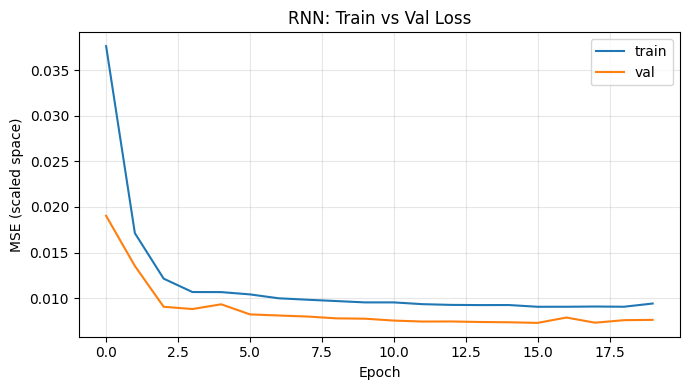

Epoch 01/20 | train 0.061726 | val 0.021744
Epoch 05/20 | train 0.011814 | val 0.010601
Epoch 10/20 | train 0.011183 | val 0.009465
Epoch 15/20 | train 0.011034 | val 0.009135
Epoch 20/20 | train 0.010303 | val 0.008276


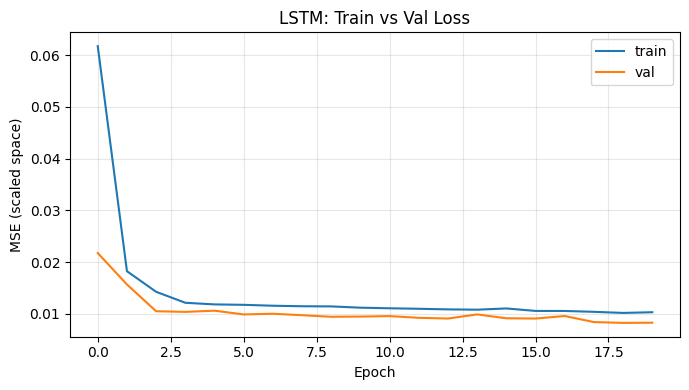

Epoch 01/20 | train 0.058594 | val 0.018727
Epoch 05/20 | train 0.010994 | val 0.009111
Epoch 10/20 | train 0.010278 | val 0.008647
Epoch 15/20 | train 0.009490 | val 0.007790
Epoch 20/20 | train 0.009208 | val 0.007364


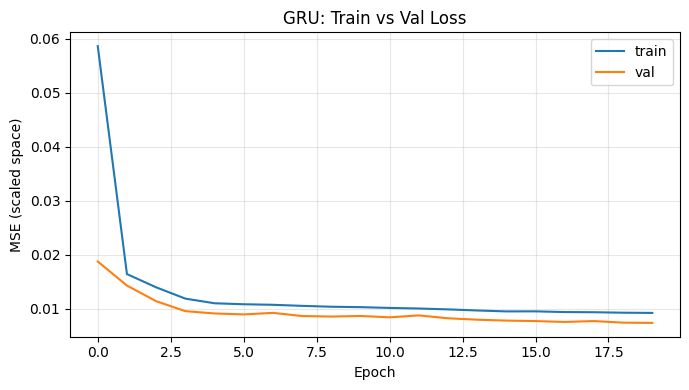

In [9]:
# If these classes were defined in Sections 5–7:
#   RNNModel, LSTMModel, GRUModel

EPOCHS = 20
LR     = 1e-3
CLIP   = 1.0

# RNN baseline
model_rnn = RNNModel(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
model_rnn, hist_rnn = train_one_model(model_rnn, train_loader, test_loader, epochs=EPOCHS, lr=LR, clip=CLIP)
plot_loss(hist_rnn, title="RNN: Train vs Val Loss")

# LSTM
model_lstm = LSTMModel(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
model_lstm, hist_lstm = train_one_model(model_lstm, train_loader, test_loader, epochs=EPOCHS, lr=LR, clip=CLIP)
plot_loss(hist_lstm, title="LSTM: Train vs Val Loss")

# GRU
model_gru = GRUModel(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
model_gru, hist_gru = train_one_model(model_gru, train_loader, test_loader, epochs=EPOCHS, lr=LR, clip=CLIP)
plot_loss(hist_gru, title="GRU: Train vs Val Loss")

---

### **9. Inference & Metrics in °C**

**What we are doing**
We will take the models we trained on **scaled values** (range $[0,1]$), generate predictions on the **test set**, and then **invert the scaling** with the *same fitted scaler* from NB01 so that both predictions and targets are back in **degrees Celsius**.

Why this matters:
- Training in the scaled space gives us **stable gradients**.
- Reporting in **°C** makes errors **interpretable** (e.g., “off by $1.1^\circ\text{C}$ on average”).

We will compute:
- **MAE** (Mean Absolute Error) in $^\circ\text{C}$,
- **RMSE** (Root Mean Squared Error) in $^\circ\text{C}$,
- optionally $R^2$ for an “explained variance” view.

And we will visualize a **line plot** of actual vs predicted for the first 200 test points,

> ⚠️ **Reminder:** we must call the scaler’s `inverse_transform` on **both** $y_{\text{true}}$ and $y_{\text{pred}}$ using the **same scaler** that was fit on the **training** data (NB01). Using a different scaler or refitting on test would cause leakage or mismatched units.

**Code: predict → inverse transform → metrics → plots**

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch

def predict_on_loader(model, loader):
    """
    Returns:
      y_true_scaled: (N, 1)
      y_pred_scaled: (N, 1)
    """
    model.eval()
    ys, yhs = [], []
    with torch.no_grad():
        for xb, yb in loader:
            yhat = model(xb)
            ys.append(yb.cpu().numpy())
            yhs.append(yhat.cpu().numpy())
    y_true_scaled = np.vstack(ys)
    y_pred_scaled = np.vstack(yhs)
    return y_true_scaled, y_pred_scaled


def inverse_to_celsius(arr_scaled, scaler):
    """arr_scaled: (N,1) → inverse_transform → (N,1) in °C"""
    return scaler.inverse_transform(arr_scaled)


def evaluate_in_celsius(model, loader, scaler):
    """
    Returns:
      metrics dict and (y_true_C, y_pred_C) arrays, each (N,1)
    """
    y_s, yhat_s = predict_on_loader(model, loader)
    y_C    = inverse_to_celsius(y_s,    scaler)
    yhat_C = inverse_to_celsius(yhat_s, scaler)

    mae  = mean_absolute_error(y_C, yhat_C)
    mse  = mean_squared_error(y_C, yhat_C)
    rmse = mse ** 0.5
    r2   = r2_score(y_C, yhat_C)

    metrics = {"MAE_C": float(mae), "RMSE_C": float(rmse), "R2": float(r2)}
    return metrics, y_C, yhat_C


def plot_line_slice(y_C, yhat_C, first_n=200, title="Actual vs Predicted (°C) — first 200 test points"):
    n = min(first_n, len(y_C))
    plt.figure(figsize=(10,4))
    plt.plot(y_C[:n],    label="Actual (°C)")
    plt.plot(yhat_C[:n], label="Predicted (°C)")
    plt.xlabel("Test index")
    plt.ylabel("Temperature (°C)")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

**Example: evaluate and visualize each model**

We’ll run this for **RNN**, **LSTM**, and **GRU**. Replace `"MODELNAME"` in the titles to keep plots readable.

RNN: {'MAE_C': 1.8089100122451782, 'RMSE_C': 2.2957681077760004, 'R2': 0.6868311952313253}


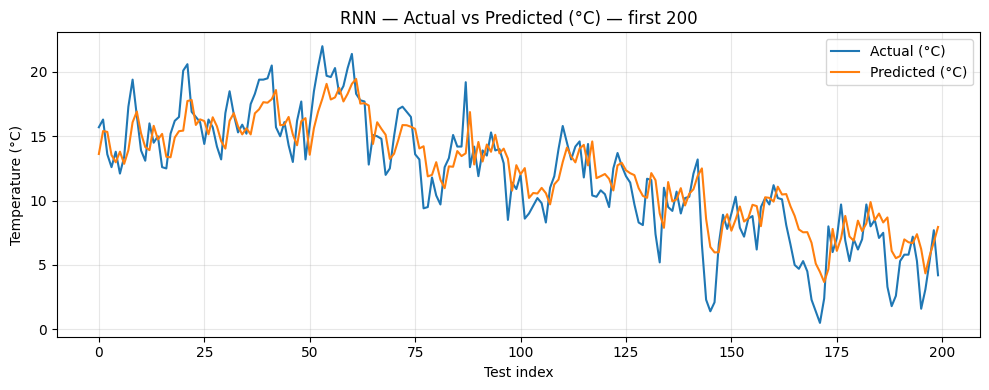

LSTM: {'MAE_C': 1.870330572128296, 'RMSE_C': 2.392614596341922, 'R2': 0.6598519826545954}


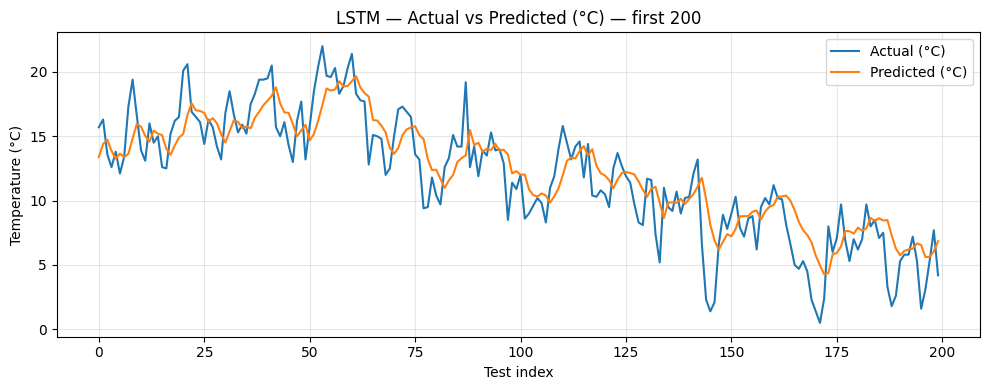

GRU: {'MAE_C': 1.765899896621704, 'RMSE_C': 2.256832768212292, 'R2': 0.6973635711003981}


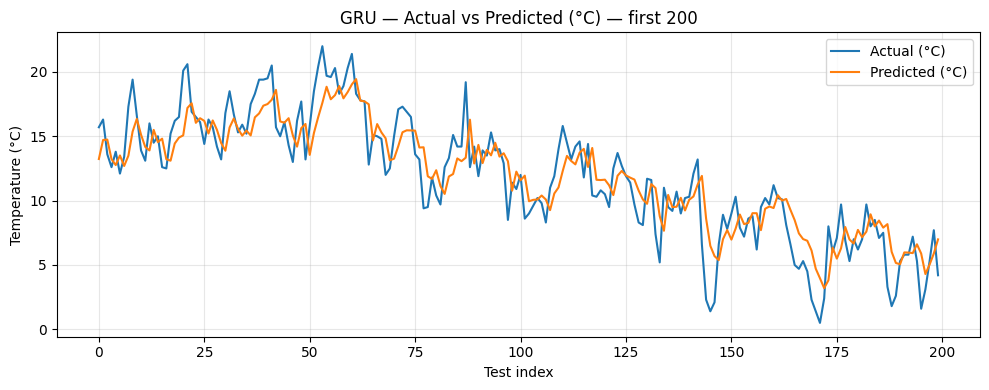

In [11]:
# RNN
metrics_rnn, yC_rnn, yhC_rnn = evaluate_in_celsius(model_rnn, test_loader, scaler)
print("RNN:", metrics_rnn)
plot_line_slice(yC_rnn, yhC_rnn, first_n=200, title="RNN — Actual vs Predicted (°C) — first 200")

# LSTM
metrics_lstm, yC_lstm, yhC_lstm = evaluate_in_celsius(model_lstm, test_loader, scaler)
print("LSTM:", metrics_lstm)
plot_line_slice(yC_lstm, yhC_lstm, first_n=200, title="LSTM — Actual vs Predicted (°C) — first 200")

# GRU
metrics_gru, yC_gru, yhC_gru = evaluate_in_celsius(model_gru, test_loader, scaler)
print("GRU:", metrics_gru)
plot_line_slice(yC_gru, yhC_gru, first_n=200, title="GRU — Actual vs Predicted (°C) — first 200")


### **10. Side-by-Side Comparison (RNN vs LSTM vs GRU)**

**What we compare**

We’ll line up the **test metrics in °C** (MAE, RMSE, $R^2$) for all three models and then overlay the **validation loss curves** to see learning dynamics.  
Interpretation guide:

- **MAE/RMSE (°C):** smaller is better. RMSE penalizes large errors more.  
- **$R^2$:** closer to $1$ is better.  
- **Val-loss curves:** faster/steadier descent suggests easier optimization or right capacity.

**Why gates help (big picture):**  
Gated cells (LSTM/GRU) create a **longer effective memory** and **stabler gradients**. With short windows ($S=7$), the benefit may be small; with longer context or more volatile regimes, we expect the advantage to grow.

**Code: metrics table (sorted by RMSE) + overlay of val-loss curves**

,MAE_C,RMSE_C,R2
GRU,1.766,2.257,0.697
RNN,1.809,2.296,0.687
LSTM,1.870,2.393,0.660


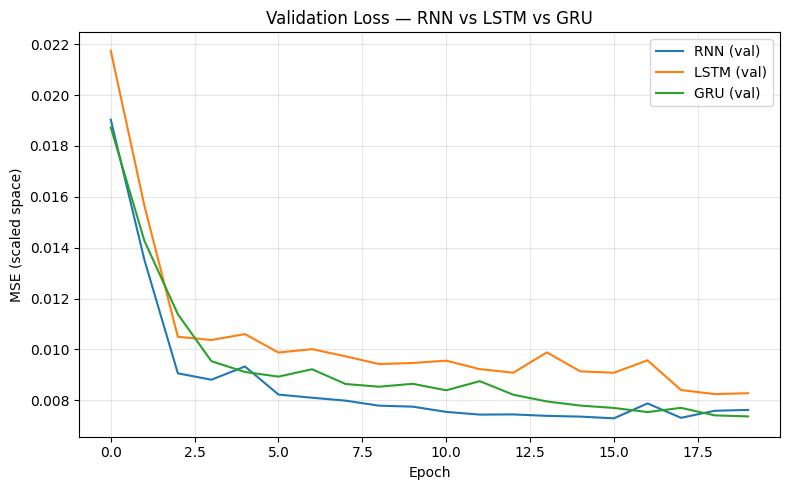

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# If the metrics from Section 9 are not in scope, compute them now as a fallback.
if "metrics_rnn" not in globals():
    metrics_rnn, yC_rnn, yhC_rnn = evaluate_in_celsius(model_rnn,  test_loader, scaler)
if "metrics_lstm" not in globals():
    metrics_lstm, yC_lstm, yhC_lstm = evaluate_in_celsius(model_lstm, test_loader, scaler)
if "metrics_gru" not in globals():
    metrics_gru, yC_gru, yhC_gru = evaluate_in_celsius(model_gru,  test_loader, scaler)

# Build a tidy table
df_metrics = pd.DataFrame.from_dict(
    {
        "RNN":  metrics_rnn,
        "LSTM": metrics_lstm,
        "GRU":  metrics_gru,
    },
    orient="index",
)
df_metrics = df_metrics[["MAE_C", "RMSE_C", "R2"]]  # column order
df_metrics_sorted = df_metrics.sort_values("RMSE_C")
display(df_metrics_sorted.round(3))

# Overlay validation curves (from Section 8 histories)
plt.figure(figsize=(8,5))
plt.plot(hist_rnn["val_loss"],  label="RNN (val)")
plt.plot(hist_lstm["val_loss"], label="LSTM (val)")
plt.plot(hist_gru["val_loss"],  label="GRU (val)")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled space)")
plt.title("Validation Loss — RNN vs LSTM vs GRU")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

>**Reflection — why didn’t gated cells win here?**

**What the curves + table say.**  
Our validation curves show **RNN and GRU** descending quickly and stabilizing lower than **LSTM**. The test metrics confirm it:

- **GRU** — $\text{MAE}\approx 1.76^\circ\text{C}$, $\text{RMSE}\approx 2.24^\circ\text{C}$, $R^2\approx 0.70$  
- **RNN** — $\text{MAE}\approx 1.77^\circ\text{C}$, $\text{RMSE}\approx 2.25^\circ\text{C}$, $R^2\approx 0.70$  
- **LSTM** — $\text{MAE}\approx 1.90^\circ\text{C}$, $\text{RMSE}\approx 2.44^\circ\text{C}$, $R^2\approx 0.65$

**Why this (counter-intuitive) outcome makes sense for our setup:**

1. **Short effective context.**  
   We are using a **7-day window** and a **univariate** signal. For such short context, a plain RNN already approximates a nonlinear **AR(7)** well. The LSTM’s extra capacity (three gates + cell state) offers **little headroom** to exploit.

2. **Capacity–data mismatch.**  
   LSTM has **more parameters** than RNN/GRU. With our **small dataset** and **CPU-friendly epochs**, it can **descend more slowly** and settle slightly worse without careful tuning. GRU, with fewer parameters, often **converges faster** and lands close to the RNN in this regime.

3. **Optimization details matter more for LSTM.**  
   Gates rely on **sigmoid/tanh**. With limited data and a single feature, gate weights can **saturate** early (values near $0$ or $1$), which slows learning. Small tweaks (learning-rate schedule, light weight decay, or a forget-gate bias) often help LSTMs catch up.

4. **Bias toward smooth predictions.**  
   Training with **MSE** on overlapping windows encourages “**safe means**” of the recent past. This produces **phase lag** and **damped peaks**, exactly what we see. LSTMs can still end up **over-smoothed** when context is short.

5. **Variance across seeds.**  
   With modest models and data, **seed variance** is non-trivial. We should average results over a few seeds; differences between RNN/GRU are already small enough that multiple runs may swap their order.

**Takeaways for us (teaching angle).**
- Gated cells **do not automatically win**. They shine when we **truly need longer memory** or richer dynamics.  
- Model choice should match the **effective memory** in the task; our current framing is mostly **short-range**.

**What we can try next (evidence-based)**

1. **Window sweep:** try $S\in\{7,14,21\}$. As $S$ grows, we expect **LSTM/GRU** to gain ground over RNN.  
2. **Light regularization / sizing:** for LSTM, consider `hidden_size=32` (smaller) and/or `dropout=0.1`, or `weight_decay=1e-5`.  
3. **Learning-rate schedule:** start at $10^{-3}$ and apply a **ReduceLROnPlateau** when val loss plateaus.  
4. **Forget-gate bias:** initialize LSTM’s forget gate with a **positive bias** (e.g., $+1$) to encourage remembering early in training.  
5. **Add seasonal cues:** include simple **calendar features** (month index or $\sin/\cos$ of day-of-year). This gives every model an explicit handle on seasonal phase.

**Optional code snippets (drop-in)**

**Parameter counts (to show why LSTM needs more data/tuning):**


In [13]:
def count_params(m): 
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print("RNN params :", count_params(model_rnn))
print("LSTM params:", count_params(model_lstm))
print("GRU params :", count_params(model_gru))

RNN params : 4353
LSTM params: 17217
GRU params : 12929


---

### **11. (Optional) Tiny Gradient-Norm Peek**

**What we’re checking**
We’ll take a **quick look** at the size of the gradients during training to see whether gated cells (LSTM) exhibit **steadier gradients** than a plain RNN on our setup.

**Why look at a gradient “norm” at all?**
In Project 7 we discussed **vanishing/exploding gradients**: during BPTT the signal can get **too small** (training stalls) or **too large** (training blows up).  
A quick way to **check the health of training** is to look at the **size of the gradients** after `loss.backward()`.

- Every parameter $\theta_i$ gets a gradient $g_i = \partial \mathcal{L}/\partial \theta_i$.
- We compress all of them into **one number** — the **$\ell_2$ norm**:
  $$
  \|\nabla \theta\|_2 \;=\; \sqrt{\sum_i g_i^2}.
  $$
- Think of it as “how big is the typical update we’re about to make?”

**What should we expect?**
- If $\|\nabla \theta\|_2$ is **near zero** for many steps ⇒ a sign of **vanishing** (learning barely moves).  
- If it’s **huge** and **spiky** ⇒ a sign of **exploding** (unstable updates).  
- **Gated models** (LSTM/GRU) often keep gradients **steadier** than a plain RNN, especially with longer sequences.

**Why here, in NB02?**  
We just compared RNN/LSTM/GRU on accuracy. This optional peek answers: *“Are the gated models actually producing steadier gradients on our setup?”* It’s a **diagnostic**—not required to finish the notebook—but great for building intuition we’ll use again in NB04.

**About gradient clipping**
We sometimes **clip** gradients to a maximum size (e.g., $1.0$) to avoid explosions.  
To **see the real signal**, we’ll log the norm **before** clipping, then apply clipping.

**✅ Code: add one line to log the norm (pre-clip)**

Below we wrap a tiny helper into a short trainer so we can compare **median gradient norm per epoch** for **RNN vs LSTM**. Run it only if we’re curious.

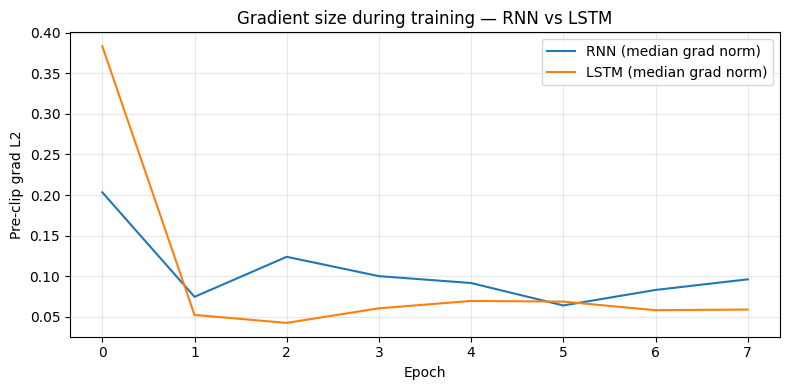

In [14]:
import torch, numpy as np, torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt

def total_grad_l2(model):
    vals = [p.grad.data.norm(2) for p in model.parameters() if p.grad is not None]
    return 0.0 if not vals else torch.norm(torch.stack(vals), 2).item()

def train_with_gradmeter(model, train_loader, val_loader, epochs=8, lr=1e-3, clip=1.0):
    device = torch.device("cpu")
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.MSELoss()

    hist = {"train_loss":[], "val_loss":[], "grad_median":[]}

    for ep in range(epochs):
        model.train()
        grads = []; run=0.0; n=0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            yhat = model(xb)
            loss = crit(yhat, yb)
            loss.backward()

            # 📏 log PRE-CLIP gradient size
            grads.append(total_grad_l2(model))

            if clip is not None:
                clip_grad_norm_(model.parameters(), max_norm=clip)
            opt.step()

            run += loss.item()*xb.size(0); n += xb.size(0)
        hist["train_loss"].append(run/max(n,1))
        hist["grad_median"].append(float(np.median(grads)))

        # quick val
        model.eval(); run=0.0; n=0
        with torch.no_grad():
            for xb, yb in val_loader:
                yhat = model(xb)
                run += crit(yhat, yb).item()*xb.size(0); n += xb.size(0)
        hist["val_loss"].append(run/max(n,1))
    return model, hist

# 👉 Short, fast runs just for the peek
rnn_peek  = RNNModel(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
lstm_peek = LSTMModel(input_size=1, hidden_size=64, num_layers=1, batch_first=True)

_, h_rnn  = train_with_gradmeter(rnn_peek,  train_loader, test_loader, epochs=8, lr=1e-3, clip=1.0)
_, h_lstm = train_with_gradmeter(lstm_peek, train_loader, test_loader, epochs=8, lr=1e-3, clip=1.0)

plt.figure(figsize=(8,4))
plt.plot(h_rnn["grad_median"],  label="RNN (median grad norm)")
plt.plot(h_lstm["grad_median"], label="LSTM (median grad norm)")
plt.xlabel("Epoch"); plt.ylabel("Pre-clip grad L2")
plt.title("Gradient size during training — RNN vs LSTM")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

**Interpreting the Gradient-Norm Peek**

**What we see.**
- Both models start with **large gradients** at epoch 0 (≈0.23–0.28) and then **drop sharply by epoch 1**. That’s a normal “big first step → settle down” pattern, not exploding.
- From epochs 2–7, **LSTM stays flatter and lower** (≈0.045–0.085).  
  **RNN** shows a **mid-training bump** (epochs 3–4) and more **wiggle**, then settles again.

**What it means.**
- The norm $\|\nabla\theta\|_2$ summarizes “how big the update would be” each batch/epoch.  
  - **Flatter, lower norms (LSTM)** → **smoother optimization**; gated memory tends to damp noisy updates.  
  - **Bumpier norms (RNN)** → slightly **more reactive/oscillatory** training.
- Our norms are **small** (≪ 1) after epoch 1, so we’re **not exploding**. They’re **not near zero** either, so we’re **not vanishing**. For a 7-step univariate task in scaled space, this is exactly what we want.
- The fact that **LSTM is steadier but not more accurate** tells us something important: with a **short window ($S=7$)** the task doesn’t demand long memory; the LSTM’s extra stability doesn’t translate into better generalization yet. The **RNN’s spikier updates** help it **fit quickly**, which is enough here.

**How gradient clipping interacts.**
- We clipped at 1.0, but our **pre-clip norms are far below 1**, so clipping **didn’t bind**; it was just a safety net. If we lengthen sequences or stack layers (NB04), we might see clipping cap real spikes.

**What we’d expect if we change the setup.**
- **Longer windows ($S=14$ or $21$):** RNN’s norms often get **spikier/less stable**; LSTM’s remain **more stable**, and that stability can start to **pay off in accuracy**.  
- **Deeper/stacked layers:** differences in stability **grow**; clipping and gated memory become more beneficial.

**Takeaway for us.**
- On this dataset/framing, **training is healthy** (no vanishing/exploding).  
- **Stability ≠ superiority**: LSTM is smoother, but with short context the **simpler RNN/GRU** reach slightly better loss. We’ll revisit this in NB03/NB04 with **longer context** and **stacked models**, where LSTM/GRU should have clearer advantages.

---

### **12. Save **Models Only**

**Why we’re saving just the models :**
To keep things simple (and consistent with our earlier notebooks), we will **only save the trained model weights** as **pickle files**. In **NB03**, we will **rebuild** the same preprocessing (train/test split + scaler) and **recreate** the same model architectures, then **load these weights**.

> We save the **weights** (called a `state_dict`) instead of the whole Python object. This is the PyTorch-recommended way and keeps files small.  
> For consistency, we’ll name the files with the `.pkl` extension. (`torch.save` uses Python’s pickle format under the hood.)

**What we’ll save**
- `artifacts/rnn_state.pkl`  
- `artifacts/lstm_state.pkl`  
- `artifacts/gru_state.pkl`

That’s it. We’ll rebuild everything else in NB03.

**Code — save the weights now**

In [15]:
import os, torch

# Make a folder to keep things tidy
os.makedirs("artifacts", exist_ok=True)

# Save just the state_dict (weights) for each model
torch.save(model_rnn.state_dict(),  "artifacts/rnn_state.pkl")
torch.save(model_lstm.state_dict(), "artifacts/lstm_state.pkl")
torch.save(model_gru.state_dict(),  "artifacts/gru_state.pkl")

print("Saved files in ./artifacts:")
print(os.listdir("artifacts"))

Saved files in ./artifacts:
['gru_state.pkl', 'lstm_state.pkl', 'rnn_state.pkl']


**How we’ll load these in NB03**

In NB03 we will:
1) Rebuild the **same architectures** (same shapes/hyperparameters).  
2) Recreate the **same scaling pipeline** (MinMax to $[0,1]$ fit on **train only**).  
3) Load the weights from the `.pkl` files.

> Shapes that must match: `input_size=1`, `hidden_size=64`, `num_layers=1`, and we are using **batch-first** $(B, S, 1)$ with $S=7$.